## Installations needed for Erda to work

In [2]:
!pip install -U pip tensorflow tensorboard mediapipe tensorflow plotly scikeras tensorrt scikeras

  Using cached tensorboard-2.13.0-py3-none-any.whl (5.6 MB)


In [5]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd


# Used to create training and testing data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Used for Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten
from tensorflow.keras.callbacks import TensorBoard
import keras
#Used for parameter tuning
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

#For accuracy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

2023-05-31 15:21:24.893849: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-31 15:21:24.946019: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-31 15:21:24.947213: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 15:21:25.860863: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
os.getcwd()

'/home/jovyan/work/Bachelorproject/src'

# 1. Importing and Splitting Data

In [6]:
X_train = np.load('../export_data/pca_trainVR.npy')
y_train = np.load('../export_data/y_pca_trainVR.npy')
X_test = np.load('../export_data/pca_testVR.npy')
y_test = np.load('../export_data/y_pca_testVR.npy')

In [7]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(159, 12)
(54, 12)
(159, 9)
(54, 9)


In [9]:
X = np.append(X_train, X_test)
y = np.append(y_train, y_test)
X = np.reshape(X, (213,12,1))
y = np.reshape(y, (213,9,1))

In [10]:
X.shape
y.shape

(213, 9, 1)

In [11]:
X_train = np.reshape(X_train, (159,12,1))

In [12]:
print(X_train.shape)

(159, 12, 1)


In [13]:
for i in range (y_train.shape[1]):
    print("Number of words in " + str(i) + " category: " + str(np.count_nonzero(y_test[:,i])))

Number of words in 0 category: 6
Number of words in 1 category: 4
Number of words in 2 category: 7
Number of words in 3 category: 5
Number of words in 4 category: 5
Number of words in 5 category: 8
Number of words in 6 category: 7
Number of words in 7 category: 6
Number of words in 8 category: 6


# 2. Neural Network Implementation

### Saving Logs

In [7]:
tracing_logs = TensorBoard(os.path.join('Logs'))

### LSTM Implementation

In [14]:
def create_model(neurons):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, activation='relu', input_shape=(12,1)))
    model.add(Flatten())
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model
model = KerasClassifier(model=create_model, verbose=0)


In [15]:
# define the grid search parameters
neurons = [8, 16, 32, 64]
learn_rate = [0.001, 0.01, 0.1]
epochs = [50, 100]
param_grid = dict(model__neurons=neurons, optimizer__learning_rate=learn_rate, epochs=epochs)
search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=KerasClassifier(model=<function create_model at 0x7fbf91c02a60>, verbose=0),
             param_grid={'epochs': [50, 100], 'model__neurons': [8, 16, 32, 64],
                         'optimizer__learning_rate': [0.001, 0.01, 0.1]})

In [16]:
search.best_score_


0.936491935483871

In [17]:
search.best_params_


{'epochs': 100, 'model__neurons': 32, 'optimizer__learning_rate': 0.01}

In [19]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(12,1)))
model.add(Flatten())
model.add(Dense(y_train.shape[1], activation='softmax'))
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(X_train, y_train, epochs = 100)


Epoch 1/100
5/5 [==============================] - 1s 12ms/step - loss: 1.7232 - categorical_accuracy: 0.3459
Epoch 2/100
5/5 [==============================] - 0s 24ms/step - loss: 0.8569 - categorical_accuracy: 0.6730
Epoch 3/100
5/5 [==============================] - 0s 25ms/step - loss: 0.4833 - categorical_accuracy: 0.8239
Epoch 4/100
5/5 [==============================] - 0s 22ms/step - loss: 0.3720 - categorical_accuracy: 0.8868
Epoch 5/100
5/5 [==============================] - 0s 24ms/step - loss: 0.4464 - categorical_accuracy: 0.8805
Epoch 6/100
5/5 [==============================] - 0s 24ms/step - loss: 0.2510 - categorical_accuracy: 0.9245
Epoch 7/100
5/5 [==============================] - 0s 24ms/step - loss: 0.1857 - categorical_accuracy: 0.9560
Epoch 8/100
5/5 [==============================] - 0s 24ms/step - loss: 0.1517 - categorical_accuracy: 0.9623
Epoch 9/100
5/5 [==============================] - 0s 25ms/step - loss: 0.1223 - categorical_accuracy: 0.9686
Epoch 10/1

# 3. Visualizing Epoch progress of NN

Train: 0.836


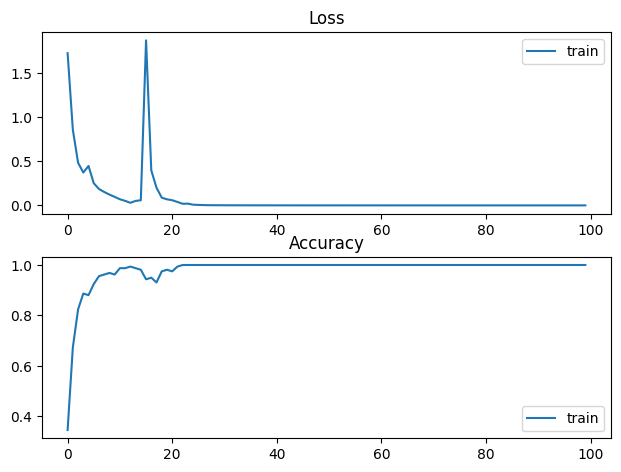

In [20]:
# evaluate the model
_, train_acc = model.evaluate(X, y, verbose=0)
print('Train: %.3f' % (train_acc))
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.tight_layout(pad=1.0)
plt.title('Accuracy')
plt.plot(history.history['categorical_accuracy'], label='train')
plt.legend()
plt.savefig('MediapipeAccuracyPlot.png')

# 3. Saving complete NN model

In [21]:
model.save('../export_data/PCA_nn_modelVR.h5')

In [22]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(tf.argmax(y_test, axis=1), tf.argmax(y_pred, axis=1)))

2/2 [==============================] - 0s 4ms/step
Accuracy: 0.35185185185185186
